In [30]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [31]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [32]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import EfficientNetB3
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [33]:
import os
import random
import matplotlib.pyplot as plt
data_path = 'chest_xray/data'
def oversampler(class_name, class_count):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = data_path + '/' + class_name
    save_dir = curr_dir
    images = os.listdir(curr_dir)
    img = plt.imread(curr_dir + '/' + random.choice(images))
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    

    cnt = class_count
    target = 3500
    for batch in datagen.flow(img, batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
        cnt += 1
        img = plt.imread(curr_dir + '/' + random.choice(images))
        img = np.expand_dims(img, axis=-1)
        img = np.expand_dims(img, axis=0)
        if cnt >= target:
            break

def undersampler(class_name, class_count):
    target_count = 3500
    curr_dir = data_path + '/' + class_name
    images = os.listdir(curr_dir)
    images_to_delete = random.sample(images, class_count - target_count)
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        os.remove(img_path)

In [34]:
import os
classes = os.listdir('chest_xray/data')
class_counts = [len(os.listdir('chest_xray/data/' + x)) for x in classes]
for i in range(len(classes)):
    print(classes[i], class_counts[i])
    undersampler(classes[i], class_counts[i])
    

Normal 3500
Pneu 3500


In [35]:
import random
import shutil

train_path = "train"
val_path = "val"
test_path = "test"

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)
    
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)   
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val
    
    train_images = images[:num_train]
    val_images = images[num_train:num_train+num_val]
    test_images = images[num_train+num_val:]
    
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))
    
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))
    
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")

Dataset split completed successfully.


In [36]:
from keras.utils import image_dataset_from_directory
val_dir = "val"
train_dir = "train"
test_dir = 'test'
train_path = "train"
val_path = "val"
test_path = "test"
image_size = (256, 256)
batch_size = 32
# Define ImageDataGenerators for loading and preprocessing the data


train_dataset = image_dataset_from_directory(
    train_path,
    image_size=image_size,
    batch_size=batch_size,
    seed=123
)
class_names = train_dataset.class_names
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

test_dataset = image_dataset_from_directory(
    test_path,
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

Found 4900 files belonging to 2 classes.
Found 1050 files belonging to 2 classes.
Found 1050 files belonging to 2 classes.


In [37]:
base_model = EfficientNetB3(weights="imagenet",include_top=False,input_shape=(256,256,3))
base_model.trainable=False
x=base_model.output
x=GlobalAveragePooling2D()(x)
feature_extractor=Model(inputs=base_model.input,outputs=x)

feature_shape=feature_extractor.output_shape[1]

In [38]:
from keras.applications.efficientnet import preprocess_input
def extract_features(dataset):
    features = []
    labels = []
    for batch, label_batch in dataset:
        # Preprocess the images
        batch = preprocess_input(batch)
        # Extract features using EfficientNetB3
        feature_batch = base_model(batch)
        feature_batch = tf.reshape(feature_batch, (feature_batch.shape[0], -1))
        features.append(feature_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features and labels for the training and validation datasets
train_features, train_labels = extract_features(train_dataset)
test_features, test_labels = extract_features(test_dataset)
val_features, val_labels = extract_features(val_dataset)

In [39]:
# Flatten train_features and val_features
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)

# Ensure labels are 1D
# train_labels = np.argmax(train_labels, axis=1)
# val_labels = np.argmax(val_labels, axis=1)

In [40]:
# Train Random Forest
import joblib
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_labels)
joblib.dump(rf_classifier, 'random_forest_model.pkl')

# Validate Random Forest
val_pred = rf_classifier.predict(val_features)
print(f'Validation Accuracy: {accuracy_score(val_labels, val_pred)}')

Validation Accuracy: 0.9657142857142857


In [41]:
test_pred = rf_classifier.predict(test_features)
print(f'Validation Accuracy: {accuracy_score(test_labels, test_pred)}')

Validation Accuracy: 0.9752380952380952


<Figure size 2000x500 with 0 Axes>

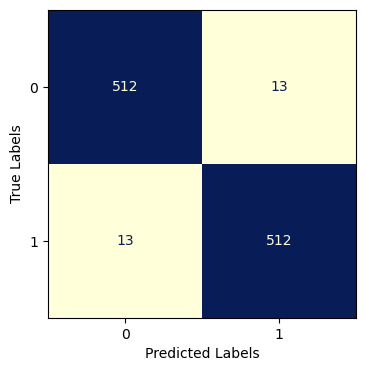

In [42]:
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
cm = confusion_matrix(test_labels, test_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, colorbar=False, cmap='YlGnBu')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [43]:
results = classification_report(test_labels, test_pred, target_names=['Normal', 'Pneumonia'])
print(results)

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       525
   Pneumonia       0.98      0.98      0.98       525

    accuracy                           0.98      1050
   macro avg       0.98      0.98      0.98      1050
weighted avg       0.98      0.98      0.98      1050

